## Import Library

In [1]:
from __future__ import division
import collections
import random
import cv2, os
import numpy as np
import pandas as pd
import h5py
import random

import matplotlib.pyplot as plt
from functools import partial, update_wrapper
from itertools import product
from IPython.display import HTML, display
import tabulate

import skimage.io as io
import skimage.transform as trans
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import keras
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


## 1. Load Data

In [2]:
building  = h5py.File(r'D:\land_cover\data\processed\Building.h5', 'r')
building  = np.array(building.get('Building')).astype(np.float32)
print(building.shape)
print("----------------------")

road      = h5py.File(r'D:\land_cover\data\processed\Road.h5', 'r')
road      = np.array(road.get('Road')).astype(np.float32)
print(road.shape)
print("----------------------")

water     = h5py.File(r'D:\land_cover\data\processed\Water.h5', 'r')
water     = np.array(water.get('Water')).astype(np.float32)
print(water.shape)
print("----------------------")

harvested = h5py.File(r'D:\land_cover\data\processed\Harvested.h5', 'r')
harvested = np.array(harvested.get('Harvested')).astype(np.float32)
print(harvested.shape)
print("----------------------")

forest = h5py.File(r'D:\land_cover\data\processed\Forest.h5', 'r')
forest = np.array(forest.get('Forest')).astype(np.float32)
print(forest.shape)
print("----------------------")

planted = h5py.File(r'D:\land_cover\data\processed\Planted.h5', 'r')
planted = np.array(planted.get('Planted')).astype(np.float32)
print(planted.shape)

(70, 256, 256, 5)
----------------------
(73, 256, 256, 5)
----------------------
(117, 256, 256, 5)
----------------------
(168, 256, 256, 5)
----------------------
(279, 256, 256, 5)
----------------------
(297, 256, 256, 5)


## Visualize Data

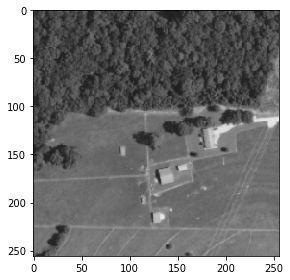

In [3]:
id_random = random.randint(0, building.shape[0])
imshow(building[id_random, :, :, 0])
plt.show()

C:\Users\amin9927\AppData\Local\ESRI\conda\envs\geoai_dl\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


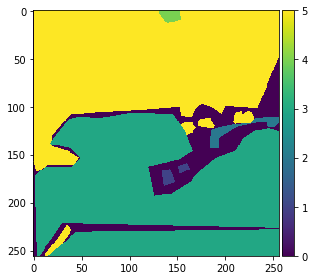

In [4]:
imshow(building[id_random, :, :, 4])
plt.show()

## 2. Data Augmentation for 3 Rare Land Cover Classes

In [3]:
def augment_data(dataset, augementation_factor=1, use_random_rotation=True, 
                 use_random_shear=True, use_random_shift=True, use_random_zoom=True):
    augmented_image        = []
    
    for num in range (0, dataset.shape[0]):
        for i in range(0, augementation_factor):
            
            # original image:
            augmented_image.append(dataset[num])
            
            rotation = [-180, -90, 90, 180]
            if use_random_rotation:
                augmented_image.append(tf.contrib.keras.preprocessing.image.random_rotation(dataset[num], random.choice(rotation), row_axis=0, col_axis=1, channel_axis=2))
            
            # shear = [0.1, 0.2, 0.3, 0.4, 0.5]
            # if use_random_shear:
            #     augmented_image.append(tf.contrib.keras.preprocessing.image.random_shear(dataset[num], random.choice(rotation), row_axis=0, col_axis=1, channel_axis=2))
            
            # if use_random_shift:
            #     augmented_image.append(tf.contrib.keras.preprocessing.image.random_shift(dataset[num], 5, 5, row_axis=0, col_axis=1, channel_axis=2))
                
            # if use_random_zoom:
            #     augmented_image.append(tf.contrib.keras.preprocessing.image.random_zoom(dataset[num], (0.05, 0.45), row_axis=0, col_axis=1, channel_axis=2))

    return np.array(augmented_image)

## Make Data for Rare Land Cover Class

In [8]:
print(building.shape)
augmented_building = augment_data(building, augementation_factor = 4)
print(augmented_building.shape)

(70, 256, 256, 5)
(560, 256, 256, 5)


In [9]:
print(road.shape)
augmented_road = augment_data(road, augementation_factor = 4)
print(augmented_road.shape)

(73, 256, 256, 5)
(584, 256, 256, 5)


In [10]:
print(water.shape)
augmented_water = augment_data(water, augementation_factor = 3)
print(augmented_water.shape)

(117, 256, 256, 5)
(702, 256, 256, 5)


In [11]:
print(harvested.shape)
augmented_harvested = augment_data(harvested, augementation_factor = 2)
print(augmented_harvested.shape)

(168, 256, 256, 5)
(672, 256, 256, 5)


In [12]:
print(forest.shape)
augmented_forest = augment_data(forest, augementation_factor = 1)
print(augmented_forest.shape)

(279, 256, 256, 5)
(558, 256, 256, 5)


In [13]:
print(planted.shape)
augmented_planted = augment_data(planted, augementation_factor = 1)
print(augmented_planted.shape)

(297, 256, 256, 5)
(594, 256, 256, 5)


## Visualize Data

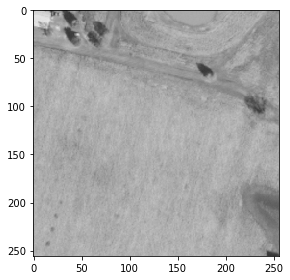

In [14]:
imshow(augmented_building[0, :, :, 0])
plt.show()

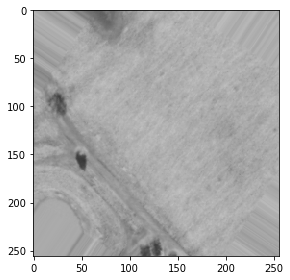

In [15]:
imshow(augmented_building[1, :, :, 0])
plt.show()

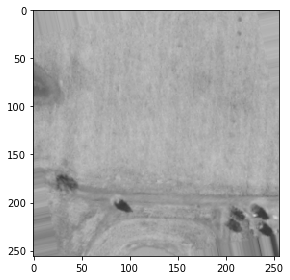

In [20]:
imshow(augmented_building[3, :, :, 0])
plt.show()

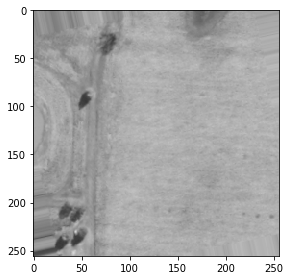

In [22]:
imshow(augmented_building[5, :, :, 0])
plt.show()

## Vertical Stack Numpy Arrays

In [23]:
print(building.shape)
print(augmented_building.shape)
print(road.shape)
print(augmented_road.shape)
rare_class = np.vstack([augmented_building, augmented_road])
print(rare_class.shape)

(70, 256, 256, 5)
(560, 256, 256, 5)
(73, 256, 256, 5)
(584, 256, 256, 5)
(1144, 256, 256, 5)


In [24]:
print(rare_class.shape)
print(water.shape)
print(augmented_water.shape)
rare_class = np.vstack([rare_class, augmented_water])
print(rare_class.shape)

(1144, 256, 256, 5)
(117, 256, 256, 5)
(702, 256, 256, 5)
(1846, 256, 256, 5)


In [25]:
harvested_sample = augmented_harvested
print(harvested_sample.shape)

(672, 256, 256, 5)


In [26]:
forest_sample = augmented_forest
print(forest_sample.shape)

(558, 256, 256, 5)


In [27]:
planted_sample = augmented_planted
print(planted_sample.shape)

(594, 256, 256, 5)


## Vertical Stack Numpy Arrays

In [28]:
# print(harvested.shape)
print(harvested_sample.shape)
# print(forest.shape)
print(forest_sample.shape)
often_class = np.vstack([harvested_sample, forest_sample])
# often_class = np.vstack([harvested, forest])
print(often_class.shape)

(672, 256, 256, 5)
(558, 256, 256, 5)
(1230, 256, 256, 5)


In [29]:
print(often_class.shape)
# print(planted.shape)
print(planted_sample.shape)
# often_class = np.vstack([often_class, planted])
often_class = np.vstack([often_class, planted_sample])
print(often_class.shape)

(1230, 256, 256, 5)
(594, 256, 256, 5)
(1824, 256, 256, 5)


## 4. Stack Often with Rare Class

In [30]:
print(rare_class.shape)
print(often_class.shape)
data = np.vstack([rare_class, often_class])
print(data.shape)

(1846, 256, 256, 5)
(1824, 256, 256, 5)
(3670, 256, 256, 5)


## Visualzie Data

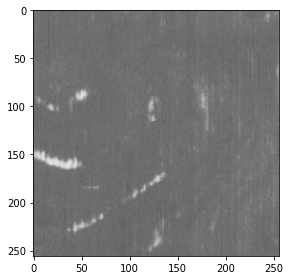

In [31]:
id_random = random.randint(0, data.shape[0])
imshow(data[id_random, :, :, 0])
plt.show()

C:\Users\amin9927\AppData\Local\ESRI\conda\envs\geoai_dl\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


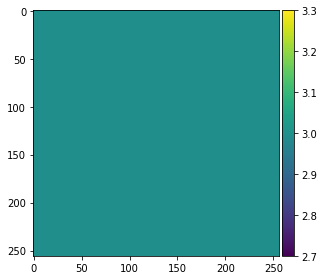

In [32]:
imshow(data[id_random, :, :, 4])
plt.show()

## 5. Shuffle Numpy Array Randomly

In [33]:
print(data.shape)
print(data[0, 0:5, 0:5, 0])
print("-----------------------------------------------------------------------")
np.random.shuffle(data)
print(data.shape)
print(data[0, 0:5, 0:5, 0])

(3670, 256, 256, 5)
[[0.5804 0.6784 0.7882 0.8314 0.8235]
 [0.6863 0.7843 0.8196 0.8392 0.8275]
 [0.7804 0.851  0.8314 0.8314 0.8314]
 [0.8157 0.8471 0.8392 0.8392 0.8431]
 [0.8745 0.8392 0.851  0.8549 0.8471]]
-----------------------------------------------------------------------
(3670, 256, 256, 5)
[[0.27730653 0.27786037 0.2784142  0.2884826  0.31444356]
 [0.28295353 0.28122506 0.27949658 0.2912894  0.310904  ]
 [0.36637554 0.36554483 0.3647141  0.38175353 0.4005768 ]
 [0.3932802  0.39369467 0.39410916 0.40958884 0.4256556 ]
 [0.3652969  0.36598828 0.36667967 0.3802831  0.38922808]]


## Visualzie Data

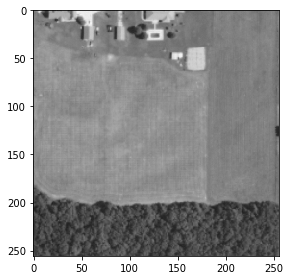

In [34]:
id_random = random.randint(0, data.shape[0])
imshow(data[id_random, :, :, 0])
plt.show()

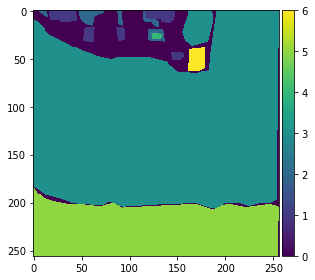

In [35]:
imshow(data[id_random, :, :, 4])
plt.show()

## 6. Separate Label Dim from Rest of Array

In [36]:
print(data.shape)
images = data[:, :, :, 0:4]
print(images.shape)

(3670, 256, 256, 5)
(3670, 256, 256, 4)


In [37]:
print(data.shape)
labels = data[:, :, :, 4]
print(labels.shape)

(3670, 256, 256, 5)
(3670, 256, 256)


## Convert Label Channel to Int

In [38]:
print(images.dtype)
print(labels.dtype)

float32
float32


In [39]:
print(labels[0, 0:5, 0:5])

[[0.        0.        0.        0.        0.       ]
 [1.4313024 1.3431146 1.2549268 1.166739  1.0785512]
 [5.        5.        5.        5.        5.       ]
 [5.        5.        5.        5.        5.       ]
 [5.        5.        5.        5.        5.       ]]


In [40]:
labels = labels.astype(int)
print(labels.dtype)

int32


In [41]:
print(labels[0, 0:5, 0:5])

[[0 0 0 0 0]
 [1 1 1 1 1]
 [5 5 5 5 5]
 [5 5 5 5 5]
 [5 5 5 5 5]]


## 7. Write/Read Labels and Images Numpy To/From HDF5

In [42]:
Images_hf  = h5py.File(r'D:\land_cover\data\processed\images.h5', 'w')
print(images.shape)
Images_hf.create_dataset('Images', data = images)
Images_hf.close()

(3670, 256, 256, 4)


In [43]:
Labels_hf  = h5py.File(r'D:\land_cover\data\processed\labels.h5', 'w')
print(labels.shape)
Labels_hf.create_dataset('Labels', data = labels)
Labels_hf.close()

(3670, 256, 256)


In [4]:
Images_hf = h5py.File(r'D:\land_cover\data\processed\images.h5', 'r')
print(Images_hf.keys())
images = np.array(Images_hf.get('Images'))
print(images.shape)

OSError: Unable to open file (file signature not found)

In [ ]:
Labels_hf = h5py.File(r'D:\land_cover\data\processed\labels.h5', 'r')
print(Labels_hf.keys())
labels = np.array(Labels_hf.get('Labels'))
print(labels.shape)

## 8. Conver Label to One Hot Vector

In [46]:
print(labels.shape)
labels = keras.utils.to_categorical(labels, num_classes = 7)
print(labels.shape)

(3670, 256, 256)
(3670, 256, 256, 7)


## 9. Define IoU Metric

In [2]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis = 0)

## 10. Define Custom Loss Function

In [3]:
class_weights = np.array([0.0000001, 1, 1, 1, 1, 1, 1])
weights       = K.variable(class_weights)

def weighted_categorical_crossentropy(y_true, y_pred):
    # scale predictions so that the class probas of each sample sum to 1
    y_pred /= K.sum(y_pred, axis = -1, keepdims = True)
    # clip to prevent NaN's and Inf's
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # calculate loss and weight loss
    loss = y_true * K.log(y_pred) * weights
    loss = -K.sum(loss, -1)
    return loss

## 11. Set Parameters before Training

In [49]:
Img_Width    = 256
Img_Height   = 256
Img_Channels = 4
Num_Classes  = 7

## Land Cover Classes

In [50]:
table = [["Background", 0],
         ["Buildings", 1],
         ["Roads/Parking Lots/Driveways", 2],
         ["Planted/Darker Cropland", 3],
         ["Water", 4],
         ["Forest", 5],
         ["Harvested/Open/Bare", 6]]
display(HTML(tabulate.tabulate(table, tablefmt = 'html')))

Background,0
Buildings,1
Roads/Parking Lots/Driveways,2
Planted/Darker Cropland,3
Water,4
Forest,5
Harvested/Open/Bare,6


## Define Inputs and Targets Dim

In [51]:
inputs  = Input((Img_Height, Img_Width, Img_Channels))
print(inputs.shape)
targets = Input((Img_Height, Img_Width, Num_Classes))
print(targets.shape)

(?, 256, 256, 4)
(?, 256, 256, 7)


## 12. Model Architecture

In [52]:
c1 = Conv2D(16, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (inputs)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (c4)
p4 = MaxPooling2D(pool_size = (2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides = (2, 2), padding = 'same') (c8)
u9 = concatenate([u9, c1], axis = 3)
c9 = Conv2D(16, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (c9)

outputs = Conv2D(7, (1, 1), activation = 'softmax') (c9)
print(outputs.shape)

(?, 256, 256, 7)


In [53]:
model   = Model(inputs = [inputs], outputs = [outputs])

In [54]:
model.compile(optimizer = 'adam', loss = weighted_categorical_crossentropy, metrics = [mean_iou])

In [55]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 592         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        dropout_1[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [25]:
plot_model(model, to_file = r'D:\land_cover\images\u_net_model_plot.png', 
           show_shapes = True, show_layer_names = True)

## 13. Fit Model

In [5]:
earlystopper = EarlyStopping(patience = 5, verbose = 1)
checkpointer = ModelCheckpoint(r'D:\land_cover\models\model_epochs_05.h5', verbose = 1, save_best_only = True)
results      = model.fit(images, labels, validation_split = 0.10, batch_size = 8, epochs = 5,   
                         callbacks = [earlystopper, checkpointer])

NameError: name 'model' is not defined

## 14. Inference

## Load Model

In [6]:
model = load_model(r'D:\land_cover\models\model_epochs_05.h5', 
                   custom_objects = {'mean_iou': mean_iou, 'weighted_categorical_crossentropy': weighted_categorical_crossentropy})

## Prediction

In [63]:
predict_prob = model.predict(images[0:10, :, :, :])
print(predict_prob.shape)
predict_class = predict_prob.argmax(axis = -1)
print(predict_class.shape)

(10, 256, 256, 7)
(10, 256, 256)


(256, 256, 4)


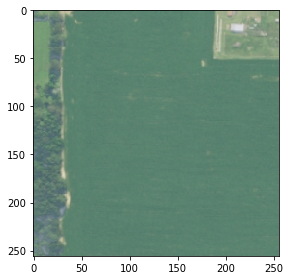

In [64]:
num = 0
print(images[num, :, :, :].shape)
imshow(images[num, :, :, :])
plt.show()

(256, 256)


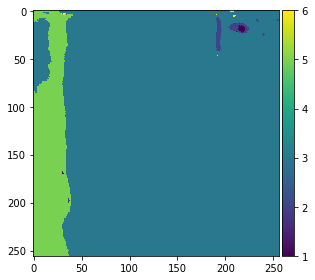

In [65]:
print(predict_class[num, :, :].shape)
imshow(predict_class[num, :, :])
plt.show()